In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import random
import seaborn as sns
import itertools as it
import pulp
import time


sys.path.append(os.path.join(os.getcwd(), '../main'))
from spatial_generation import Spatial, GroupSpatial
from elections import SNTV,Bloc,STV,Borda, ChamberlinCourant, Monroe, GreedyCC, PluralityVeto, SMRD, OMRD, DMRD, ExpandingApprovals
from utils import euclidean_distance, cost, costs, best_group_cost, remove_candidates, borda_matrix, group_representation, max_group_representation, qmin_cost
from election_sampling import election_sample, samples

%load_ext autoreload
%autoreload 2

In [2]:
colors = ["#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd","#8dd3c7",
        "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#bc80bd",
        "#ccebc5","#ffed6f","#ffffb3","#a6cee3","#1f78b4","#b2df8a","#33a02c",
        "#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#b15928",
        "#64ffda","#00B8D4","#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB",
        "#D81B60","#26A69A","#FFEA00","#6200EA",
    ]
colors2 = colors[:6] + colors[-12::2]
custom_colors = ListedColormap(colors2)

In [4]:
# Choose number of voters n and the number of candidates m
n = 200
m = 50

# Choose the number of winners for the election
k = 20

### Gaussian

In [5]:
# define the single set of voter and candidate paramters
voter_params = {'loc': [0,0], 'scale': 1, 'size': 2}
candidate_params = {'loc': [0,0], 'scale': 1, 'size': 2}

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
gaussian_generator = Spatial(voter_dist = np.random.normal, voter_params = voter_params,
                    candidate_dist = np.random.normal, candidate_params = candidate_params,
                    distance = distance)

In [6]:
# Now each call .generate() will make a profile with random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = gaussian_generator.generate(n, m)

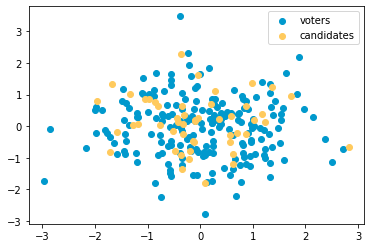

In [7]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

### Uniform Disc

In [8]:
# samples a single point uniformly from a disc with defined radius
def sample_uniform_disc(radius=1):
    # Sample angles uniformly from 0 to 2*pi
    theta = np.random.uniform(0, 2 * np.pi, 1)
    
    # Sample radii with correct distribution
    r = radius * np.sqrt(np.random.uniform(0, 1, 1))
    
    # Convert polar coordinates to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))[0]

In [9]:
voter_params = {'radius': 1}
candidate_params = {'radius': 1}
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

disc_generator = Spatial(voter_dist = sample_uniform_disc, voter_params = voter_params,
                    candidate_dist = sample_uniform_disc, candidate_params = candidate_params,
                    distance = distance)

In [10]:
# Now each call .generate() will make a profile with random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = disc_generator.generate(n, m)

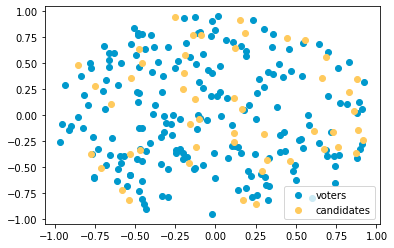

In [11]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

### Uniform Square

In [12]:
# define the single set of voter and candidate paramters
voter_params = {'low': 0, 'high': 1, 'size': 2}
candidate_params = {'low': 0, 'high': 1, 'size': 2}

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
square_generator = Spatial(voter_dist = np.random.uniform, voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [13]:
# Now each call .generate() will make a profile with random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = square_generator.generate(n, m)

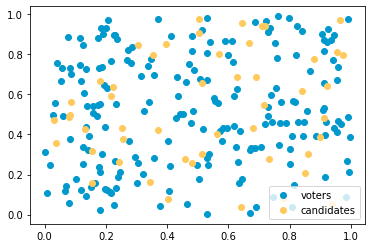

In [14]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

### 4-gaussian

In [15]:
# Means for each of the 4 Normal distributions
means = [[-2, 0], [2, 0], [0, 2], [0, -2]]
stds = [0.5, 0.5, 0.5, 0.5]  # Standard deviations for each Normal
four_party_G = [25, 25, 25, 25]  # Group Sizes

# Create a list of voter parameters -- with each set of parameters being a dict
voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(four_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
four_party_generator = GroupSpatial(voter_groups = 4, candidate_groups = 4,
                    voter_dists = [np.random.normal]*len(four_party_G), voter_params = voter_params,
                    candidate_dists = [np.random.normal]*len(four_party_G), candidate_params = voter_params,
                    distance = distance)

In [16]:
# Now each call .generate() will make a profile with random candidate and voter positions
size_dist = [1/4, 1/4, 1/4, 1/4]
profile, candidate_positions, voter_positions, voter_labels = four_party_generator.generate(n, m,
                                        voter_size_dist = size_dist, candidate_size_dist = size_dist, exact = False)

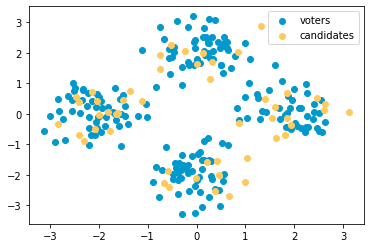

In [17]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

### Voronoi Generation

In [137]:
import math
from itertools import combinations
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from scipy.optimize import linprog
from scipy.spatial import Delaunay

In [27]:
enumerate(combinations(range(3), 2))

In [38]:
# Choose number of voters n and the number of candidates m
n = 200
m = 3

# Choose the number of winners for the election
k = 3

In [101]:
candidate_positions = np.random.uniform(0,1, size = (m,2))

In [102]:
lines = np.zeros((math.comb(m,2), 3))

for i, candidate_pair in enumerate(combinations(range(m), 2)):
    c1 = candidate_pair[0]
    c2 = candidate_pair[1]  
    slope = (candidate_positions[c2,1] - candidate_positions[c1,1]) / (candidate_positions[c2,0] - candidate_positions[c1,0])
    slope = -1/slope
    midpoint = np.mean(candidate_positions[candidate_pair,:], axis = 0)
    lines[i, 0] = slope
    lines[i, 1] = -1
    lines[i, 2] = midpoint[1] - slope*midpoint[0]
    
border = np.array([[0,1,0], [0,1,-1], [1,0,0], [1,0,-1]])
lines = np.vstack((lines,border))
    
vertices = []
for i, line_pair in enumerate(combinations(range(len(lines)), 2)):
    l1 = line_pair[0]
    l2 = line_pair[1]
    
    a1, b1, c1 = lines[l1,:]
    a2, b2, c2 = lines[l2,:]
    
    # Create the coefficient matrix and the constant vector
    A = np.array([[a1, b1], [a2, b2]])
    B = np.array([-c1, -c2])
    
    # Solve the system of equations
    try:
        intersection = np.linalg.solve(A, B)
        if intersection[0] >= 0 and intersection[0] <= 1:
            if intersection[1] >= 0 and intersection[1] <= 1:
                vertices.append(intersection)
    except np.linalg.LinAlgError:
        pass
    
vertices = np.array(vertices)
    

In [105]:
vertices

array([[ 0.52787181,  0.61429337],
       [ 0.52787181,  0.61429337],
       [ 0.13605949, -0.        ],
       [ 0.77388554,  1.        ],
       [ 0.52787181,  0.61429337],
       [-0.        ,  0.55087455],
       [ 1.        ,  0.67101513],
       [ 0.68085599, -0.        ],
       [ 0.43181508,  1.        ],
       [-0.        , -0.        ],
       [ 1.        , -0.        ],
       [-0.        ,  1.        ],
       [ 1.        ,  1.        ]])

In [120]:
hull1 = [8, 3, 0]
hull2 = [3, 12, 6, 0]
hull3 = [6, 10, 7, 0]
hull4 = [7, 2, 0]
hull5 = [2, 9, 5, 0]
hull6 = [5, 11, 8, 0]

hulls = [hull1,hull2,hull3,hull4,hull5,hull6]
hulls = [vertices[h,:] for h in hulls]
hulls = [ConvexHull(h) for h in hulls]

areas = [h.volume for h in hulls]

In [ ]:
def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

In [138]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [159]:
n = 100

In [160]:
hull_assignment = np.random.choice(range(len(hulls)), n, p = areas)
voter_positions = []

for a in hull_assignment:
    found = False
    while not found:
        random_point = np.random.uniform(0,1, size = 2)
        #if hull_path.contains_point([0.5,1]):
        if in_hull(random_point, hulls[a].points):
            voter_positions.append(random_point)
            found = True

In [161]:
voter_positions = np.array(voter_positions)

(-0.2, 1.2)

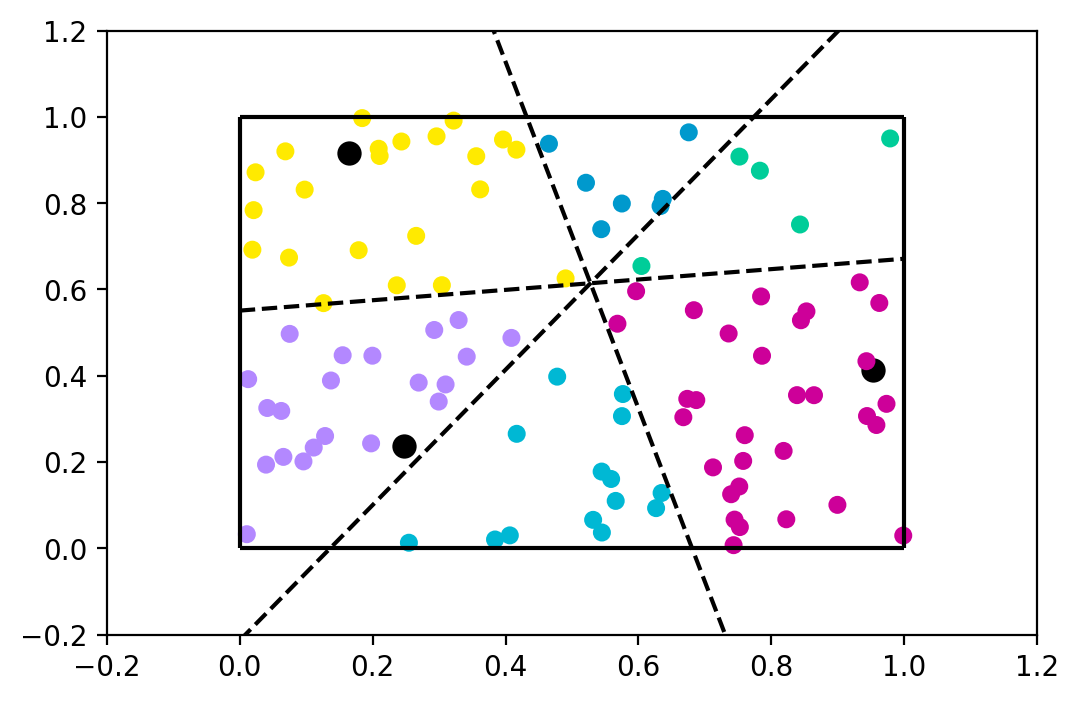

In [163]:
fig,ax = plt.subplots(dpi = 200)
ax.scatter(candidate_positions[:,0], candidate_positions[:,1], s = 60, c = 'k')
ax.scatter(voter_positions[:,0], voter_positions[:,1], c = hull_assignment, s = 30, cmap = custom_colors)

x = np.linspace(0,1,10)

for l in range(len(lines) - 4):
    y = (-lines[l, 0]*x - lines[l,2])/lines[l,1]
    ax.plot(x,y, linestyle = '--', c = 'k')
    
ax.vlines(x = 0, ymin = 0, ymax = 1, color = 'k')
ax.vlines(x = 1, ymin = 0, ymax = 1, color = 'k')
ax.hlines(y = 0, xmin = 0, xmax = 1, color = 'k')
ax.hlines(y = 1, xmin = 0, xmax = 1, color = 'k')

ax.set_ylim(-0.2,1.2)
ax.set_xlim(-0.2,1.2)

In [83]:
y

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, nan])

In [21]:
from itertools import combinations

In [25]:
list(combinations(range(m), 2))

[(0, 1), (0, 2), (1, 2)]